In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import tensorflow as tf
import keras.backend as K
from keras.optimizers import Adam
from datagen import SequenceDataGenerator
from embedding_model import SequenceEmbeddingModel, sequence_loss_with_params
from params import Params
from IPython.display import clear_output
from utils import *
from evaluate import eval_pair

Using TensorFlow backend.


In [2]:
params = Params()

params.EMBEDDING_DIM            = 12
params.BATCH_SIZE               = 1
params.NUM_SHAPE                = 3
params.NUM_CLASSES              = params.NUM_SHAPE + 1
params.NUM_FILTER               = [256, 256, 128]
params.ETH_MEAN_SHIFT_THRESHOLD = 1.5
params.DELTA_VAR                = 0.5
params.DELTA_D                  = 1.5
params.IMG_SIZE                 = 128
params.OUTPUT_SIZE              = 32
params.SEQUENCE_LEN             = 20
params.BACKBONE                 = 'xception'
params.TASK                     = 'sequence'
params.COLORS                   = np.random.random((params.NUM_SHAPE+1, 3))

In [3]:
LEARNING_RATE = 1e-4

model = SequenceEmbeddingModel(params)
optim = Adam(lr = LEARNING_RATE)
loss_function = sequence_loss_with_params(params)
model.compile(optim, loss = loss_function)
# clear_output()
dg = SequenceDataGenerator(
    num_shape    = params.NUM_SHAPE, 
    image_size   = params.IMG_SIZE,
    sequence_len = params.SEQUENCE_LEN)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



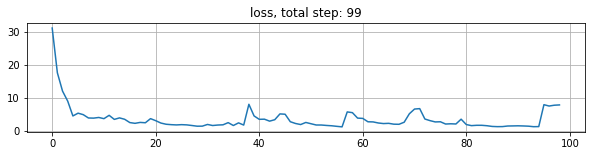

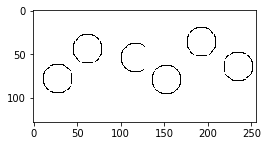

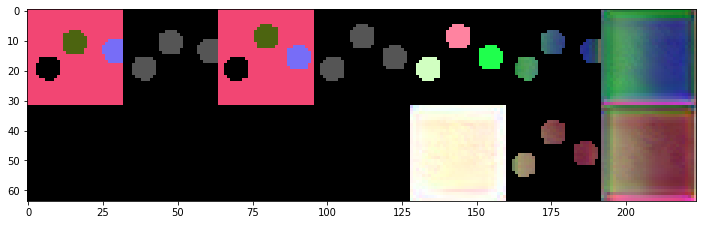

In [ ]:
EPOCHS = 100
nan = float('nan')
step = 0
loss_history = []

for epoch in range(EPOCHS):
    for _ in range(100):
        sequence = dg.get_sequence()
        for i in range(params.SEQUENCE_LEN - 1):
            step += 1
            image_info = sequence[i]
            prev_image_info = sequence[i+1]
            x, y = prep_double_frame(image_info, prev_image_info, params)
            history = model.fit(x, y, batch_size = 1, verbose = False)
            loss_history.append(history.history['loss'][-1])
            if step % 20 == 19:
                clear_output()
                visualize_history(loss_history, f'loss, total step: {step}')
                sequence = dg.get_sequence()
                pair = sequence[0:2]
                eval_pair(model, pair, params)
    model.save('sequence.h5')

In [ ]:
dg = SequenceDataGenerator(
    num_shape    = params.NUM_SHAPE, 
    image_size   = params.IMG_SIZE,
    sequence_len = params.SEQUENCE_LEN)
sequence = dg.get_sequence()
image_info = sequence[0]
prev_image_info = sequence[1]
x, y = prep_double_frame(image_info, prev_image_info, params)
outputs = np.random.rand(1, 64, 64, 34)

In [ ]:
K.clear_session()

y_true = tf.placeholder(dtype = tf.float32, shape = (1, 64, 64, 6))
y_pred = tf.placeholder(dtype = tf.float32, shape = (1, 64, 64, 34))

# hyperparameters
delta_var     = params.DELTA_VAR
delta_d       = params.DELTA_D
class_num     = params.NUM_CLASSES
embedding_dim = params.EMBEDDING_DIM

# unpack ground truth contents
class_mask_gt      = y_true[:, :, :, 0]
prev_class_mask_gt = y_true[:, :, :, 1]
identity_mask      = y_true[:, :, :, 2]
prev_identity_mask = y_true[:, :, :, 3]
optical_flow_gt    = y_true[:, :, :, 4:5]

# y_pred
class_mask_pred      = y_pred[:, :, :, :class_num]
prev_class_mask_pred = y_pred[:, :, :, class_num:(class_num * 2)]
instance_emb         = y_pred[:, :, :, (class_num * 2):(class_num * 2 + embedding_dim)]
prev_instance_emb    = y_pred[:, :, :, (class_num * 2 + embedding_dim):(class_num * 2 + embedding_dim * 2)]
optical_flow_pred    = y_pred[:, :, :, (class_num * 2 + embedding_dim * 2):]

# flatten and combine
# --identity mask gt
identity_mask_flat            = K.flatten(identity_mask)
prev_identity_mask_flat       = K.flatten(prev_identity_mask)
combined_identity_mask_flat   = tf.concat((identity_mask_flat, prev_identity_mask_flat), axis=0)
# --instance embedding pred
instance_emb_flat             = tf.reshape(instance_emb, shape=(-1, embedding_dim))
prev_instance_emb_flat        = tf.reshape(prev_instance_emb, shape=(-1, embedding_dim))
combined_instance_emb_flat     = tf.concat((instance_emb_flat, prev_instance_emb_flat), axis=0)
# --class mask gt
class_mask_gt_flat            = K.flatten(class_mask_gt)
prev_class_mask_gt_flat       = K.flatten(prev_class_mask_gt)
combined_class_mask_gt_flat   = tf.concat((class_mask_gt_flat, prev_class_mask_gt_flat), axis=0)
# --class mask pred
class_mask_pred_flat          = tf.reshape(class_mask_pred, shape=(-1, class_num))
prev_class_mask_pred_flat     = tf.reshape(prev_class_mask_pred, shape=(-1, class_num))
combined_class_mask_pred_flat = tf.concat((class_mask_pred_flat, prev_class_mask_pred_flat), axis=0)

# get number of pixels and clusters (without background)
num_cluster = tf.reduce_max(combined_identity_mask_flat)
num_cluster = tf.cast(num_cluster, tf.int32)

# cast masks into tf.int32 for one-hot encoding
combined_identity_mask_flat = tf.cast(combined_identity_mask_flat, tf.int32)
combined_class_mask_gt_flat = tf.cast(combined_class_mask_gt_flat, tf.int32)

# one-hot encoding
combined_identity_mask_flat -= 1
combined_identity_mask_flat_one_hot = tf.one_hot(combined_identity_mask_flat, num_cluster)
conbined_class_mask_gt_flat_one_hot = tf.one_hot(combined_class_mask_gt_flat, class_num)

# ignore background pixels
non_background_idx                  = tf.greater(combined_identity_mask_flat, -1)
combined_instance_emb_flat          = tf.boolean_mask(combined_instance_emb_flat, non_background_idx)
combined_identity_mask_flat         = tf.boolean_mask(combined_identity_mask_flat, non_background_idx)
combined_identity_mask_flat_one_hot = tf.boolean_mask(combined_identity_mask_flat_one_hot, non_background_idx)
combined_class_mask_gt_flat         = tf.boolean_mask(combined_class_mask_gt_flat, non_background_idx)

# center count
center_count = tf.reduce_sum(tf.cast(combined_identity_mask_flat_one_hot, dtype=tf.float32), axis=0)

# variance term
embedding_sum_by_instance = tf.matmul(
    tf.transpose(combined_instance_emb_flat), tf.cast(combined_identity_mask_flat_one_hot, dtype=tf.float32))
centers = tf.divide(embedding_sum_by_instance, center_count)
gathered_center = tf.gather(centers, combined_identity_mask_flat, axis=1)
gathered_center_count = tf.gather(center_count, combined_identity_mask_flat)
combined_emb_t = tf.transpose(combined_instance_emb_flat)
var_dist = tf.norm(combined_emb_t - gathered_center, ord=1, axis=0) - delta_var
# changed from soft hinge loss to hard cutoff
var_dist_pos = tf.square(tf.maximum(var_dist, 0))
var_dist_by_instance = tf.divide(var_dist_pos, gathered_center_count)
num_cluster = tf.cast(num_cluster, tf.float32)
variance_term = tf.reduce_sum(var_dist_by_instance) / num_cluster

# get instance to class mapping
class_mask_gt = tf.expand_dims(class_mask_gt, axis=-1)
# multiply classification with one hot flat identity mask
combined_identity_mask_flat_one_hot = tf.cast(combined_identity_mask_flat_one_hot, tf.float32)
combined_class_mask_gt_flat = tf.cast(combined_class_mask_gt_flat, tf.float32)
combined_class_mask_gt_flat = tf.expand_dims(combined_class_mask_gt_flat, 1)
filtered_class = tf.multiply(combined_identity_mask_flat_one_hot, combined_class_mask_gt_flat)
# shrink to a 1 by num_of_cluster vector to map instance to class;
# by reduce_max, any class other than 0 (background) stands out
instance_to_class = tf.reduce_max(filtered_class, axis = [0])

def distance_true_fn(num_cluster_by_class, centers_by_class):
    centers_row_buffer = tf.ones((embedding_dim, num_cluster_by_class, num_cluster_by_class))
    centers_by_class = tf.expand_dims(centers_by_class, axis=2)
    centers_row = tf.multiply(centers_row_buffer, centers_by_class)
    centers_col = tf.transpose(centers_row, perm=[0, 2, 1])
    dist_matrix = centers_row - centers_col
    idx2 = tf.ones((num_cluster_by_class, num_cluster_by_class))
    diag = tf.ones((1, num_cluster_by_class))
    diag = tf.reshape(diag, [-1])
    idx2 = idx2 - tf.diag(diag)
    idx2 = tf.cast(idx2, tf.bool)
    idx2 = K.flatten(idx2)
    dist_matrix = tf.reshape(dist_matrix, [embedding_dim, -1])
    dist_matrix = tf.transpose(dist_matrix)
    sampled_dist = tf.boolean_mask(dist_matrix, idx2)
    distance_term = tf.square(tf.maximum(
        2 * delta_d - tf.norm(sampled_dist, ord=1, axis=1), 0))
    distance_term = tf.reduce_sum(
        distance_term) / tf.cast(num_cluster_by_class * (num_cluster_by_class - 1) + 1, tf.float32)
    return distance_term


def distance_false_fn():
    return 0.0


distance_term_total = 0.0
# center distance term
for i in range(class_num-1):
    class_idx = tf.equal(instance_to_class, i+1)
    centers_transpose = tf.transpose(centers)
    centers_by_class_transpose = tf.boolean_mask(centers_transpose, class_idx)
    centers_by_class = tf.transpose(centers_by_class_transpose)
    num_cluster_by_class = tf.reduce_sum(tf.cast(class_idx, tf.float32))
    num_cluster_by_class = tf.cast(num_cluster_by_class, tf.int32)
    distance_term_subtotal = tf.cond(num_cluster_by_class > 0, 
                                    lambda: distance_true_fn(num_cluster_by_class, centers_by_class), 
                                    lambda: distance_false_fn())
    distance_term_total += distance_term_subtotal

# regularization term
regularization_term = tf.reduce_mean(tf.norm(tf.squeeze(centers), ord=1, axis=0))

# sum up terms
instance_emb_sequence_loss = variance_term + distance_term_total + 0.01 * regularization_term
semseg_loss = K.mean(K.categorical_crossentropy(
    tf.cast(conbined_class_mask_gt_flat_one_hot, tf.float32), 
    tf.cast(combined_class_mask_pred_flat, tf.float32)))
optical_flow_loss = tf.reduce_mean(tf.square(optical_flow_pred - optical_flow_gt))
loss = instance_emb_sequence_loss + semseg_loss + optical_flow_loss
loss = tf.reshape(loss, [-1])

with tf.Session() as sess:
    [loss_] = sess.run(
        [loss], 
        feed_dict = {'Placeholder:0': y, 'Placeholder_1:0': outputs})